In [1]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
import pickle

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Loading avdsr model with default init

In [2]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.002)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=(), config=0) #CHECK
#     config.network_fn = lambda: SRNetCNN(config.action_dim, SRIdentityBody(config.state_dim), 
#                                          hidden_units=(2000,), config=0)
    config.replay_fn = lambda: Replay(memory_size=int(4e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e1
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    return agent
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [3]:
avdsr = avdsr_feature(game='FourRoomsMatrixNoTerm', agents=[], choice=0)

2020-10-29 09:16:37,657 - wandb.jupyter - ERROR: Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2020-10-29 09:16:37,790 - wandb.run_manager - INFO: system metrics and metadata threads started
2020-10-29 09:16:37,793 - wandb.run_manager - INFO: checking resume status, waiting at most 10 seconds
2020-10-29 09:16:37,870 - wandb.run_manager - INFO: file/dir created: /home/mila/p/penmetss/trash/DeepRLv3/notebooks/wandb/run-20201029_091636-32a77c7n/wandb-metadata.json
2020-10-29 09:16:37,909 - wandb.run_manager - INFO: resuming run from id: UnVuOnYxOjMyYTc3YzduOnNhbXBsZS1wcm9qZWN0OnBzdXJ5YQ==
2020-10-29 09:16:37,941 - wandb.run_manager - INFO: upserting run before process can begin, waiting at most 10 seconds
2020-10-29 09:16:38,083 - wandb.run_manager - INFO: saving pip packages
2020-10-29 09:16:38,088 - wandb.run_manager - IN

### Updating weights of avdsr from saved files

In [4]:
iters = 300000
weights = torch.load('../storage/01-avdsr.weights', map_location='cpu').state_dict()
# weights = torch.load('../storage/20-'+str(iters)+'-avdsr.weights', map_location='cpu').state_dict()
avdsr.network.load_state_dict(weights,strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Visualizing the learnt SRs

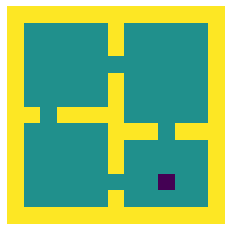

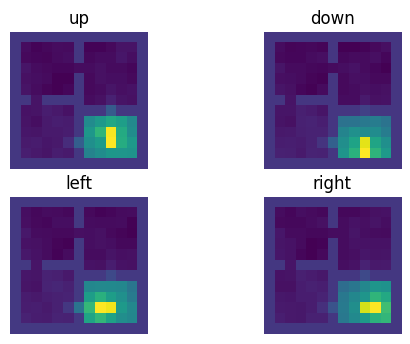

In [5]:
from deep_rl.component.fourrooms import *
# import matplotlib
# matplotlib.rc('axes',edgecolor='black')
g = [21, 28, 84, 91]
env = FourRoomsMatrix(layout='4rooms')
state = env.reset(init=g[3])
plt.imshow(env.render(show_goal=False))
plt.axis('off')
plt.savefig('../storage/fig5.4-f.png')
plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().cpu().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.axis('off')
# plt.suptitle('Fine-tuning: '+ str(iters) + ' iterations')
plt.savefig('../storage/fig5.4-j.png')
plt.show()

### Plotting the PCA for all values in env

In [6]:
from deep_rl.component.fourrooms import *
g = [21, 28, 84, 91]
c = np.ones(104)*4
room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
connect = [25, 51, 62, 88]
c[room1] = 1
c[room2] = 2
c[room3] = 3
c[connect] = [-1, -1, -1, -1]
env = FourRoomsMatrix(layout='4rooms')
psi_all = np.zeros((104,169*4))
for i in range(104):
    state = env.reset(init=i)
    _, out, _ = avdsr.network(tensor(state).unsqueeze(0))
    psi = out.detach().cpu().numpy()
    psi_all[i,:] = psi.flatten()

psi_all.shape

(104, 676)

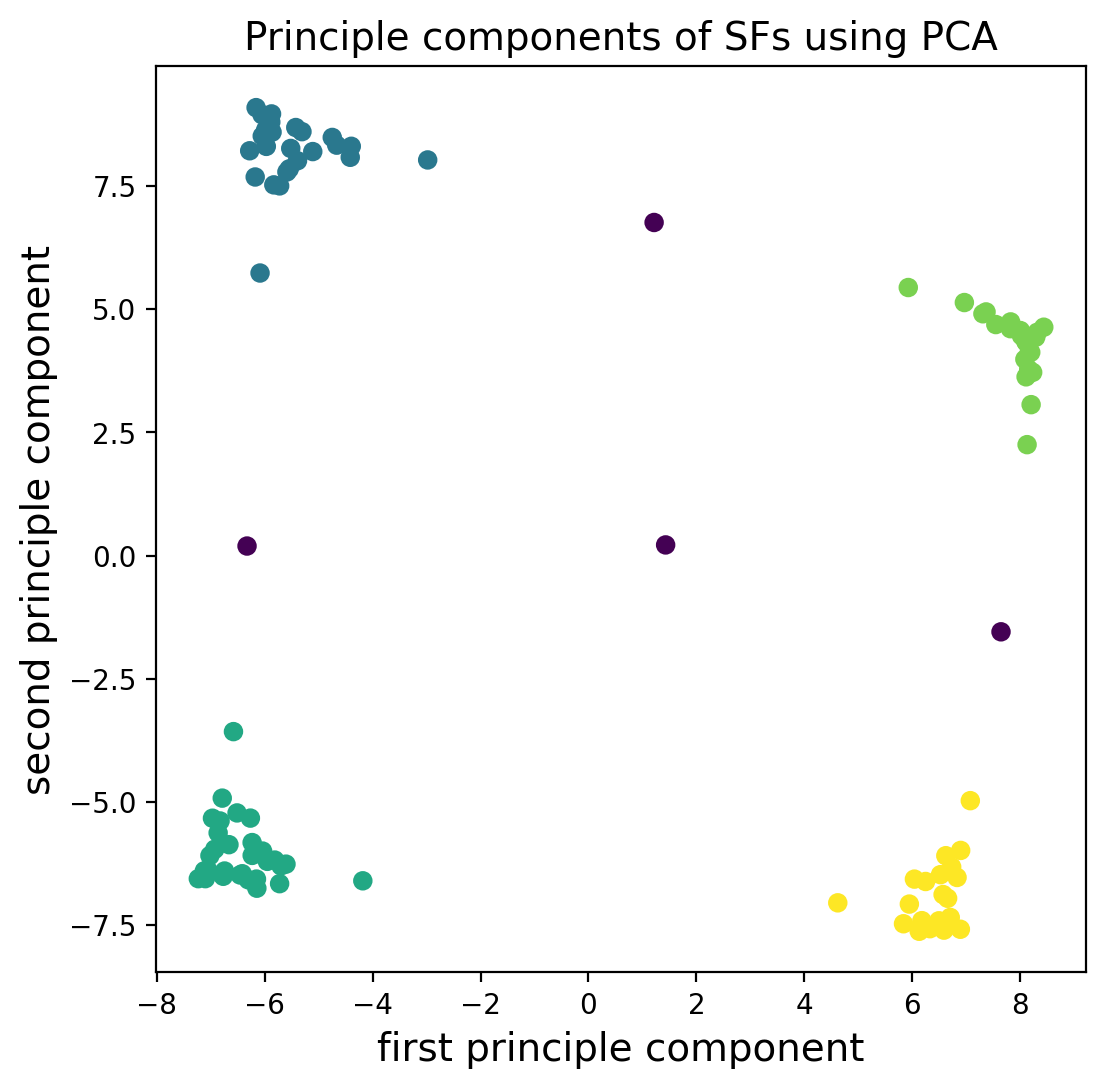

In [16]:
from sklearn.decomposition import PCA
plt.figure(figsize=(6,6),dpi=200)
pca = PCA(n_components=2)
k = pca.fit_transform(psi_all)
plt.scatter(k[:,0],k[:,1], c=c)
plt.xlabel('first principle component', fontsize=14)
plt.ylabel('second principle component', fontsize=14)
# plt.colorbar()
plt.title('Principle components of SFs using PCA', fontsize=14)
plt.savefig('../storage/fig5.4-b.png')